# Expected Value of Cost function in population setting

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Generate $n$D Data

In [828]:
def generate_data_nD(length, n, A):
    
    # Initialize series
    series = np.array(np.zeros((length, n)))
    
    inv_P = np.linalg.inv(P)
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t] = np.matmul(inv_P, np.matmul(A, np.matmul(P, series[t - 1])) + np.random.multivariate_normal(np.zeros(n), Sigma))
    
    return series

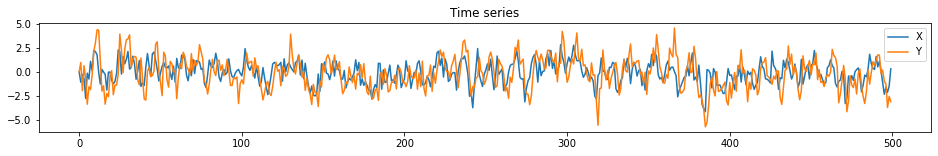

In [1196]:
np.random.seed(seed = 123)

length, n = 500, 2
A, P, Sigma = None, None, None 

if n == 2:
    A = np.array([[0.5, 0.0], [0.8, 0.4]])
    P = np.array([[1.0, 0.0], [0.0, 1.0]])
    Sigma = np.identity(n)
elif n == 3:
    A = np.array([[0.5, 0.0, 0.0], [0.3, 0.4, 0.0], [0.2, 0.0, 0.6]])
    Sigma = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    
elif n == 4:
    
    P = np.array([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0]])


# Generate nD data
series = generate_data_nD(length, n, A)

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

As, Ps = A.copy(), P.copy()

# Cost Function
$$C(A, P, A^*, P^*) = \left\lVert X_{t, val} - X_{t,pred}\right\rVert_2^2,$$
where we use the following value to predict $X_t$:
$$X_{t,pred} = P^{-1}APX_{t-1}$$
In reality, there is some underlying $P^*$, $A^*$ used to generate $X_{t,val}:$
$$X_{t, val} = P^{*-1}A^*P^*X_{t-1} + \Sigma.$$

This means that the cost function is 
$$C(A, P, A^*, P^*) = \left\lVert P^{*-1}A^*P^*X_{t-1} + \Sigma- P^{-1}APX_{t-1}\right\rVert_2^2,$$

## Distribution of $X$
We assume that $X_1 \sim \mathcal{N}\left(\mathbf{0}, \Sigma\right)$. Then, the distribution of $X_t$, where $t$ can be any integer, will be

$$X_t \sim \mathcal{N}\left(0, \Sigma_X\right),$$

where $$\text{vec}(\Sigma_X) = \left(I_{n^2} - B^* \otimes B^*\right)^{-1} \text{vec}(\Sigma),$$

and $$B^* = P^{*-1} A^* P^*.$$

More specifically, we have

$$\Sigma_X = \left(\text{vec}\left(I_n\right)^T \otimes I_m\right)\left(I_n \otimes \text{vec}(\Sigma_X) \right).$$

In [1152]:
def expected_cost(A, P, As = As, Ps = Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

We see that the analytic approach and the data sampling approach yield almost identical results, with the data sampling approach converging to the analytic approach when we take an infinite amount of samples.
## Expected cost when using $P^*$ and $A^*$
\begin{align*}\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right] &= \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right) \\
&= \text{Tr}\left(\Sigma + \left(B^* - B^*\right)\Sigma_X\left(B^* - B^*\right)^T\right) \\
&= \text{Tr}\left(\Sigma\right).
\end{align*}
Hence, we see that we achieve the minimum for $P^*$ and $A^*$.

In [1153]:
def C_n(A = As, P = Ps):
    """
    Given that series has been generated according to P*, A*,
    This function returns the cost when using estimates P, A.
    """
    
    cost = 0

    P_inv = np.linalg.inv(P)

    for t in range(1, length):
        val = series[t]
        est = np.matmul(P_inv, np.matmul(A, np.matmul(P, series[t - 1])))
        cost += np.linalg.norm(val - est) ** 2

    return cost / (length - 1)

print("Expected Cost when using P* and A*:", np.trace(Sigma))
print("Expected Cost when using P* and A*:", expected_cost(As, Ps))
print("Cost from data when using P* and A*:", round(C_n(), 3))

Expected Cost when using P* and A*: 3.0
Expected Cost when using P* and A*: 3.0
Cost from data when using P* and A*: 2.846


# Distribution of $\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]$
To derive the expectation of the cost, we first rewrite to
\begin{align*}
    \mathbb{E}\left[\left\lVert X_{t, val} - X_{t,pred}\right\rVert_2^2\right] &= \mathbb{E}\left[\sum_{i=1}^n \left(X_{t,val,i} - X_{t,pred,i} \right)^2\right]\\
    &= \text{Tr}\left(\mathbb{V}\left(X_{t,val} - X_{t, pred})\right)\right) \\
\end{align*}
coSo, we see that we need to determine the covariance of $X_{t,val} - X_{t,pred}$, or rather its trace. We derive the variance as follows:

\begin{align*}
\mathbb{V}\left(X_{t,val} - X_{t, pred})\right) &= \mathbb{V}\left(P^{*-1}A^*P^* X_{t-1} + \Sigma - P^{-1}APX_{t-1})\right)\\
&= \Sigma + \mathbb{V}\left(\left(B^* - B\right)X_{t-1}\right)&\tag{Due to independence of $\Sigma$} \\
&= \Sigma + \mathbb{V}\left(\left(B^* - B\right)X_{t}\right)&\tag{$X_t$, $X_{t-1}$ have same distribution} \\
&= \Sigma + \left(B^* - B\right)\mathbb{V}\left(X_{t}\right)\left(B^* - B\right)^T &\tag{Constant out of covariance}\\
&= \Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T, \tag{Fill in $\Sigma_X$}\\
\end{align*}
where $$B^* = P^{*-1} A^* P^*,\qquad B = P^{-1} A P.$$
Hence, 
$$\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right] = \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right).$$

Furthermore, we see that the expected cost is a function of our data-generating $P^*$, $A^*$, and of our estimates $P$, $A$.

### Derivative of the population cost setting w.r.t. $A$, $P$
\begin{align*}\frac{\partial \mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]}{\partial A} &= \frac{\partial \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial A} \\
&= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial A} + \frac{\partial \text{Tr}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial A} \\ &= \frac{\partial \text{Tr}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial A} \\ &= (B^* - B)\Sigma_X^T + (B^* - B)\Sigma_X
.\end{align*}

In [1154]:
def g_expected_cost_a(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    B_grad = -np.matmul(P_inv, np.matmul(J, P))
    B_grad = -np.identity(n)
    
    covariance_X = np.identity(n) # np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    der = np.matmul(B_grad, np.matmul(Bs - B, covariance_X.transpose()) + np.matmul(Bs - B, covariance_X))

    return der

print(g_expected_cost_a(A, P, 0, 0, As, Ps))
print(g_expected_cost_a(A, P, 0, 0, As, Ps))

[[-1.1   0.15  0.15]
 [-0.3  -1.25 -0.45]
 [-0.1  -0.45 -1.65]]
[[-1.1   0.15  0.15]
 [-0.3  -1.25 -0.45]
 [-0.1  -0.45 -1.65]]


1 1, ...,  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


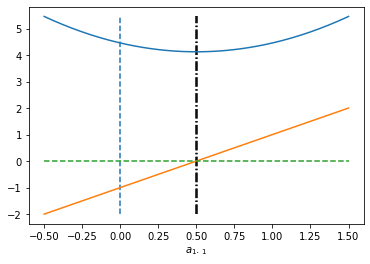

In [1155]:
A = np.zeros((n, n))
P = np.identity(n) # np.array([[0.4, 0.6], [0.6, 0.4]])
num = 300
i, j = 1, 1
print(f"{i} {j}, ..., ", end = " ")
print(A)
a_list = np.linspace(-0.5, 1.5, num)
results = [[], []]

print(A, P)
a_temp = A[i - 1][j - 1]

for a in a_list:
    A[i - 1][j - 1] = a
    results[0].append(expected_cost(A, P, As, Ps))
    der = g_expected_cost_a(A, P, i - 1, j - 1)[i - 1][j - 1]
    results[1].append(der)
A[i - 1][j - 1] = a_temp

plt.xlabel(f"$a_{i}._{j}$")

plt.plot(a_list, results[0], label = r"$C(a_{ij})$")
plt.plot(a_list, results[1], label = r"$\frac{\partial C(a_{ij})}{\partial a_{ij}}$")
plt.plot([-0.5, 1.5], [0, 0], linestyle = '--', label = r"$y = 0$")
plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(a_{ij})$", color = 'black')
plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{a}_{ij}$")

In [1156]:
der = [(j-i) * num / 2.0 for i, j in zip(results[0][:-1], results[0][1:])]
print(der[30:50])
print(results[1][30:50])

[-2.129730092504545, -2.1118332009708585, -2.0939363094373054, -2.076039417903619, -2.0581425263699327, -2.0402456348362463, -2.022348743302693, -2.004451851769007, -1.9865549602354537, -1.968658068701501, -1.9507611771682143, -1.9328642856343947, -1.9149673941005751, -1.8970705025671553, -1.8791736110333357, -1.8612767194999158, -1.8433798279660962, -1.8254829364325431, -1.8075860448987235, -1.7896891533651704]
[-1.5986622073578596, -1.585284280936455, -1.5719063545150502, -1.5585284280936456, -1.5451505016722409, -1.5317725752508362, -1.5183946488294313, -1.5050167224080266, -1.491638795986622, -1.4782608695652173, -1.4648829431438126, -1.451505016722408, -1.4381270903010033, -1.4247491638795986, -1.411371237458194, -1.3979933110367893, -1.3846153846153846, -1.37123745819398, -1.3578595317725752, -1.3444816053511706]


\begin{align*}\frac{\partial \mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]}{\partial P} &= \frac{\partial \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial P} \\
&= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial P} + \frac{\partial \text{Tr}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial P} \\ &= \frac{\partial \text{Tr}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial P} \\ &= (B^* - B)\Sigma_X^T + (B^* - B)\Sigma_X
.\end{align*}

In [1157]:
def g_expected_cost_p(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))

    J = np.zeros((n, n))
    J[i][j] = 1
    
    B_grad = -np.matmul(P_inv, np.matmul(A, J))
    B_grad += np.matmul(P_inv, np.matmul(J, np.matmul(P_inv, np.matmul(A, P))))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    B_grad = np.identity(n)
    der = np.matmul(B_grad, np.matmul(Bs - B, covariance_X.transpose()) + np.matmul(Bs - B, covariance_X))
        
    return der

A[1][0] = 0.7
print(g_expected_cost_p(A, P, 1, 1, As, Ps))

[[ 1.33333333  0.25        0.19047619]
 [-0.86666667  0.92380952 -0.01102757]
 [ 0.76190476  0.31203008  2.13690476]]


In [1239]:
def B_grad_a(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    return np.trace(-2 * np.matmul(covariance_X, np.matmul((B - Bs).transpose(), -np.matmul(P_inv, np.matmul(J, P)))))

In [1197]:
def B_grad_p(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    B_grad = -np.matmul(P_inv, np.matmul(A, J))
    B_grad += np.matmul(P_inv, np.matmul(J, np.matmul(P_inv, np.matmul(A, P))))
    
    return np.trace(-2 * np.matmul(covariance_X, np.matmul((B - Bs).transpose(), B_grad)))

1 1, ...,  

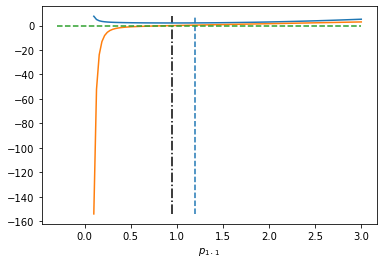

In [1231]:
A = A + 0.01
P = P + 0.1
i, j = 1, 1

print(f"{i} {j}, ..., ", end = " ")
p_list = np.linspace(0.1, 3, 100)
results = [[], []]

p_temp = P[i - 1][j - 1]

for p in p_list:
    P[i - 1][j - 1] = p
    results[0].append(B(A, P))
    results[1].append(B_grad_p(A, P, i - 1, j - 1))
                      
P[i - 1][j - 1] = p_temp

plt.xlabel(f"$p_{i}._{j}$")

plt.plot(p_list, results[0], label = r"$C(p_{ij})$")
plt.plot(p_list, results[1], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")


plt.plot([-0.3, 3], [0, 0], linestyle = '--', label = r"$y = 0$")
plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(a_{ij})$", color = 'black')
plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{a}_{ij}$")

In [1211]:
der = [(j-i) * 1000 / 6 for i, j in zip(results[0][:-1], results[0][1:])]
print(der[0:30])
print(results[1][0:30])

[-6.828369911453376, -6.818109400692644, -6.807848889929839, -6.79758837917029, -6.7873278684089655, -6.777067357647049, -6.766806846887796, -6.756546336125879, -6.746285825364258, -6.736025314603822, -6.725764803843681, -6.71550429308206, -6.705243782319847, -6.694983271560299, -6.6847227607992705, -6.674462250037945, -6.664201739276028, -6.653941228515888, -6.643680717755451, -6.633420206992942, -6.623159696233098, -6.612899185471773, -6.602638674709856, -6.592378163950603, -6.5821176531886865, -6.571857142427954, -6.561596631667517, -6.551336120904712, -6.541075610144868, -6.530815099383839]
[-6.826666666666668, -6.816416416416416, -6.806166166166165, -6.795915915915917, -6.7856656656656655, -6.775415415415415, -6.7651651651651665, -6.754914914914915, -6.744664664664665, -6.734414414414417, -6.724164164164165, -6.713913913913914, -6.703663663663663, -6.693413413413414, -6.683163163163163, -6.672912912912913, -6.662662662662663, -6.6524124124124135, -6.642162162162163, -6.63191191191

In [1242]:
def B(A, P, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))

    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    return np.trace(Sigma + np.matmul(Bs - B, np.matmul(covariance_X, (Bs - B).transpose())))

def B_grad_a_shit(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    var_1 = np.matmul(Bs - B, -np.matmul(P_inv, np.matmul(J, P)))
    var_2 = np.matmul(-np.matmul(P_inv, np.matmul(J, P)).transpose(), (Bs - B).transpose())
    
    return np.trace(var_1 + var_2)

# def B_grad_p(A, P, i, j, As = As, Ps = Ps):
#     P_inv = np.linalg.inv(P)

#     J = np.zeros((n, n))
#     J[i][j] = 1
    
#     B_grad = -np.matmul(P_inv, np.matmul(A, J))
#     B_grad += np.matmul(P_inv, np.matmul(J, np.matmul(P_inv, np.matmul(A, P))))
    
#     return B_grad

2 1, ...,  [[0.5 0. ]
 [0.8 0.4]]
[[0.5 0. ]
 [0.8 0.4]] [[1. 0.]
 [0. 1.]]


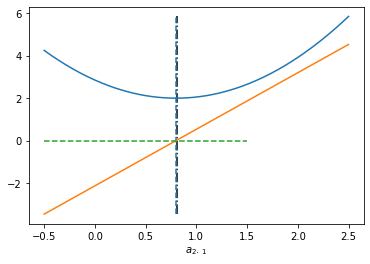

In [1241]:
A = As.copy()
P = Ps.copy()
num = 300
i, j = 2, 1
print(f"{i} {j}, ..., ", end = " ")
print(A)
a_list = np.linspace(-0.5, 2.5, num)
results = [[], []]

print(A, P)
a_temp = A[i - 1][j - 1]

for a in a_list:
    A[i - 1][j - 1] = a
    results[0].append(B(A, P, As, Ps))
    der = B_grad_a(A, P, i - 1, j - 1)
    results[1].append(der)
A[i - 1][j - 1] = a_temp

plt.xlabel(f"$a_{i}._{j}$")

plt.plot(a_list, results[0], label = r"$C(a_{ij})$")
plt.plot(a_list, results[1], label = r"$\frac{\partial C(a_{ij})}{\partial a_{ij}}$")
plt.plot([-0.5, 1.5], [0, 0], linestyle = '--', label = r"$y = 0$")
plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(a_{ij})$", color = 'black')
plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{a}_{ij}$")

In [799]:
print(As, Ps, np.matmul(np.linalg.inv(Ps), np.matmul(As, Ps)))
P = Ps.copy()
i, j = 2, 3
print(f"{i} {j}, ..., ", end = " ")
p_list = np.linspace(0.01, 0.99, 100)
results = [[], [], [], []]

p_temp = P[i - 1][j - 1]

for p in p_list:
    P[i - 1][j - 1] = p
    # results[0].append(B(A, P))
    # results[1].append(B_grad_p(A, P, i - 1, j - 1)[i - 1][j - 1])
    results[2].append(expected_cost(A, P))
    results[3].append(g_expected_cost_p(A, P, i - 1, j - 1)[i - 1][j - 1])
                      
P[i - 1][j - 1] = p_temp

plt.xlabel(f"$p_{i}._{j}$")

# plt.plot(p_list, results[0], label = r"$C(p_{ij})$")
# plt.plot(p_list, results[1], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")
plt.plot(p_list, results[2], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")
plt.plot(p_list, results[3], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")
# plt.plot([-0.1, 1.1], [0, 0], linestyle = '--', label = r"$y = 0$")
# plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(a_{ij})$", color = 'black')
# plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{a}_{ij}$")

[[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.  0.6]] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.  0.6]]
2 3, ...,  

IndexError: invalid index to scalar variable.

In [697]:
A, P = As.copy(), Ps.copy()

In [736]:
der = [(j-i) * 200 / 2 for i, j in zip(results[0][:-1], results[0][1:])]
print(der[1:10])
print(results[1][1:10])

[-2.6396639815493117, -2.6127286347987777, -2.5857932880482437, -2.5588579412977985, -2.5319225945473534, -2.5049872477967305, -2.4780519010461965, -2.4511165542957514, -2.424181207545306]
[-2.639865996649916, -2.6130653266331656, -2.5862646566164154, -2.559463986599665, -2.5326633165829144, -2.5058626465661638, -2.4790619765494135, -2.4522613065326633, -2.425460636515913]


In [134]:
P = Ps.copy()

In [770]:
i, j = 1, 2
print(f"{i} {j}, ..., ", end = " ")
print(P)
p_list = np.linspace(-0.30, 0.99, 97)
results = [[], []]

p_temp = P[i - 1][j - 1]

for p in p_list:
    P[i - 1][j - 1] = p
    results[0].append(expected_cost(A, P, As, Ps))
    # print(results[0])
    der = g_expected_cost_p(A, P)
    results[1].append(der[i - 1][j - 1])
P[i - 1][j - 1] = p_temp

plt.xlabel(f"$p_{i}._{j}$")
plt.plot(p_list, results[0], label = r"$C(p_{ij})$")
plt.show()
plt.plot(p_list, results[1], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")
plt.plot([0, 1], [0, 0], linestyle = '--', label = r"$y = 0$")
plt.show()
# plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(p_{ij})$", color = 'black')
# plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{p}_{ij}$")

1 2, ...,  [[0 0 0]
 [1 0 0]
 [0 0 1]]


LinAlgError: Singular matrix

In [211]:
der = [(j-i) * 97 / 1.29 for i, j in zip(results[0][:-1], results[0][1:])]
print(der[20:50])
print(results[1][20:50])

[-0.01503625715758787, -0.006780351669249822, 0.0014264069129696203, 0.009591457552304667, 0.017722239211855954, 0.025826190854690734, 0.03391075144397642, 0.041983359942746885, 0.05005145531420293, 0.05812247652147859, 0.06620386252760772, 0.07430305229575776, 0.08242748478899593, 0.09058459897052307, 0.098781833803373, 0.10702662825077998, 0.11532642127564426, 0.12368865184133362, 0.13212075891071498, 0.1406301814471227, 0.1492243584135906, 0.1579107287732194, 0.1666967314891097, 0.17558980552439551, 0.1845973898422443, 0.19372692340572328, 0.20298584517789972, 0.21238159412204122, 0.22192160920104803, 0.23161332937825457]
[-0.04881417410714291, -0.02762233677455353, -0.006734882812499973, 0.013848187779017862, 0.03412687500000009, 0.05410117885044648, 0.07377109933035715, 0.0931366364397321, 0.11219779017857139, 0.13095456054687504, 0.1494069475446429, 0.16755495117187497, 0.18539857142857136, 0.20293780831473213, 0.22017266183035714, 0.23710313197544636, 0.25372921875, 0.2700509221

## Verifications

### Gradient of A for $A = A^*$, $P = P^*$

1 1, ...,  1 2, ...,  2 1, ...,  2 2, ...,  

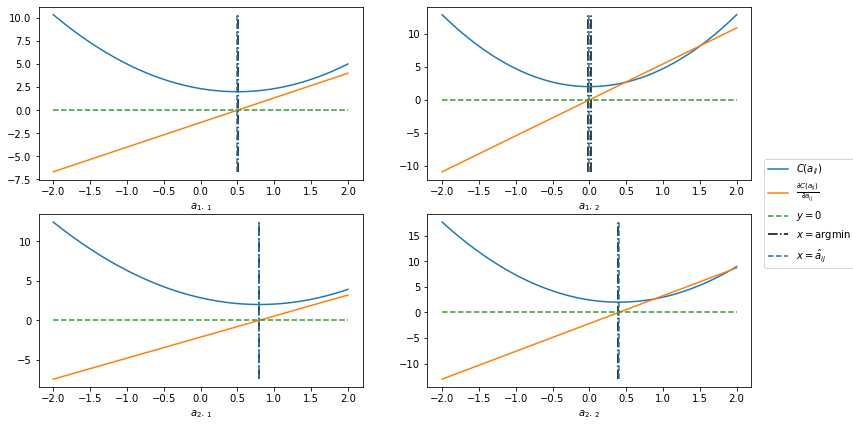

In [1270]:
def verify_gradient_a(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    a_list = np.linspace(-2, 2, 100)
    results = [[], []]
    
    a_temp = A[i - 1][j - 1]
    
    for a in a_list:
        A[i - 1][j - 1] = a
        results[0].append(expected_cost(A, P, As, Ps))
        results[1].append(B_grad_a(A, P, i - 1, j - 1))
        
    A[i - 1][j - 1] = a_temp

    plt.xlabel(f"$a_{i}._{j}$")
    
    # plt.ylim(-0.1,0.1)
    if i == 1 and j == 1:
        plt.plot(a_list, results[0], label = r"$C(a_{ij})$")
        plt.plot(a_list, results[1], label = r"$\frac{\partial C(a_{ij})}{\partial a_{ij}}$")
        plt.plot([-2, 2], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(a_{ij})$", color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{a}_{ij}$")
    else:
        plt.plot(a_list, results[0])
        plt.plot(a_list, results[1])
        plt.plot([-2, 2], [0, 0], linestyle = '--')
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')

# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = As.copy(), Ps.copy()

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_a(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

1 1, ...,  1 2, ...,  2 1, ...,  2 2, ...,  

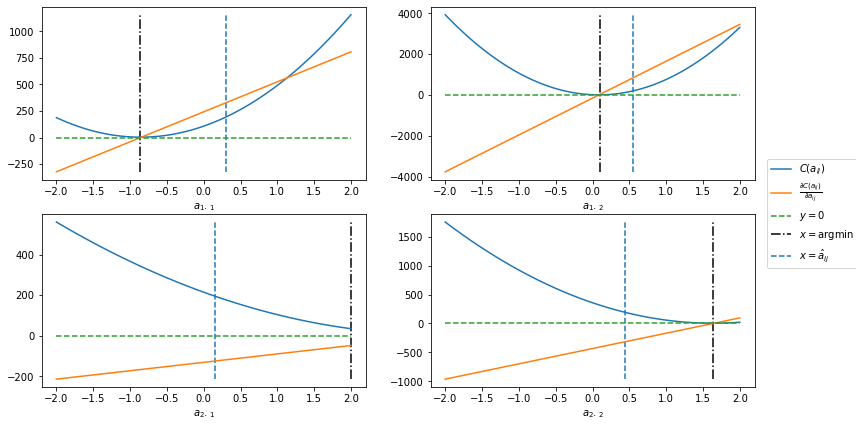

In [1271]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = np.random.rand(n, n), np.random.rand(n, n)

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_a(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

### Verify gradient of $P$ for $A = A^*$ and $P = P^*$